In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Reading the combined CSV files
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['fire_name','Unnamed: 0', 'Unnamed: 0.1','disc_date_final','cont_date_final','cont_clean_date','putout_time', 'fire_size_class', 'fire_mag', 'weather_file', 'state'])
df = df.drop(columns=['disc_clean_date', 'discovery_month', 'disc_date_pre', 'disc_pre_year', 'disc_pre_month']) # drop date columns
df = df.drop(columns=['wstation_usaf', 'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear']) # drop station columns

#Get rid of outliers - fires of size larger than 5000 acres, and there are large number of small fires and other very less number are having the high 
# area of fires, because of which the deviation is very high
df = df.loc[df['fire_size'] < 3.5]
df.columns
df.dtypes

fire_size           float64
stat_cause_descr     object
latitude            float64
longitude           float64
Vegetation            int64
Temp_pre_30         float64
Temp_pre_15         float64
Temp_pre_7          float64
Temp_cont           float64
Wind_pre_30         float64
Wind_pre_15         float64
Wind_pre_7          float64
Wind_cont           float64
Hum_pre_30          float64
Hum_pre_15          float64
Hum_pre_7           float64
Hum_cont            float64
Prec_pre_30         float64
Prec_pre_15         float64
Prec_pre_7          float64
Prec_cont           float64
remoteness          float64
dtype: object

In [3]:
profile = pandas_profiling.ProfileReport(df)
profile.to_file("Combined_Profile.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


In [3]:
df['stat_cause_descr'].unique()

array(['Arson', 'Debris Burning', 'Miscellaneous', 'Campfire',
       'Fireworks', 'Missing/Undefined', 'Children', 'Equipment Use',
       'Lightning', 'Smoking', 'Railroad', 'Structure', 'Powerline'],
      dtype=object)

In [4]:
cause_encoded_dist = {
    'Missing/Undefined':0, 
    'Arson':1, 
    'Debris Burning':2, 
    'Miscellaneous':3,
    'Campfire':4, 
    'Fireworks':5, 
    'Children':6, 
    'Lightning':7, 
    'Equipment Use':8,
    'Smoking':9, 
    'Railroad':10, 
    'Structure':11, 
    'Powerline':12
}

# Encode categorical values to numeric
df['stat_cause_descr'] = df['stat_cause_descr'].apply(lambda x: cause_encoded_dist[x]).astype(np.number)
df.head()

,fire_size,stat_cause_descr,latitude,longitude,Vegetation,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,...,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
1,3.0,1.0,35.03833,-87.6100,15,7.553433,7.010000,0.343529,10.448298,2.709764,...,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355
3,1.0,2.0,39.64140,-119.3083,0,16.275967,18.996181,18.142564,0.000000,4.054982,...,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447
4,2.0,3.0,30.70060,-90.5914,12,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633
5,1.0,2.0,32.06390,-82.4178,12,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.139643
7,1.0,4.0,30.90472,-93.5575,12,16.851939,16.997783,20.434783,11.985560,1.331257,...,2.148857,72.899478,75.061381,77.924623,70.732911,28.4,27.5,1.2,55.4,0.241894


In [5]:
# df = pd.get_dummies(df, prefix=['Cause'], columns = ['stat_cause_descr'], drop_first=True)

In [6]:
df.head()

,fire_size,latitude,longitude,Vegetation,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,...,stat_cause_descr_Debris Burning,stat_cause_descr_Equipment Use,stat_cause_descr_Fireworks,stat_cause_descr_Lightning,stat_cause_descr_Miscellaneous,stat_cause_descr_Missing/Undefined,stat_cause_descr_Powerline,stat_cause_descr_Railroad,stat_cause_descr_Smoking,stat_cause_descr_Structure
1,3.0,35.03833,-87.6100,15,7.553433,7.010000,0.343529,10.448298,2.709764,2.881707,...,0,0,0,0,0,0,0,0,0,0
3,1.0,39.64140,-119.3083,0,16.275967,18.996181,18.142564,0.000000,4.054982,3.398329,...,1,0,0,0,0,0,0,0,0,0
4,2.0,30.70060,-90.5914,12,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0,0,0,0,1,0,0,0,0,0
5,1.0,32.06390,-82.4178,12,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1,0,0,0,0,0,0,0,0,0
7,1.0,30.90472,-93.5575,12,16.851939,16.997783,20.434783,11.985560,1.331257,1.472949,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# X = df.drop(columns=['fire_size'])
# Y = df['fire_size']

X = df.drop(columns=['stat_cause_descr'])
Y = df['stat_cause_descr']


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=32)

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [7]:
from sklearn.decomposition import PCA
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [22]:
X_train_pca

array([[ 1.3689748 , -0.04393135, -0.58047111, -1.16158813, -1.65577018],
       [ 0.64321854,  0.69106465, -1.03516201, -0.04911778,  0.12244955],
       [ 0.91204948,  0.87746694, -0.11173697, -2.57546713, -1.35475439],
       ...,
       [-3.35196807,  0.58798908, -0.50041049,  0.40723479,  0.8561698 ],
       [ 2.85901199,  2.07649696, -0.66008535, -0.3819958 ,  1.85416802],
       [ 2.43851285, -2.6057349 ,  1.16118875,  0.25208461,  0.81235081]])

In [15]:
X_test_pca

array([[ 1.67646273,  1.95638466,  0.47872244,  0.03053632,  0.33329727],
       [ 1.64086731, -0.36027642,  1.07317683, -3.30186793,  0.77676539],
       [-4.08379287,  0.56923078, -0.43812162,  0.49893186, -0.2180662 ],
       ...,
       [-3.39970563,  0.83538717, -1.01552166,  0.76232633, -1.09560452],
       [-4.03812159,  0.06243629, -0.32914499,  1.30577512, -0.84767291],
       [ 2.39291283, -2.08141543,  0.03026169,  0.62252588, -0.17930328]])

In [8]:
import plotly.express as px
pca = PCA()
pca.fit(df)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [9]:
# Feature importances using RandomForest
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.882135711324378
model score on testing data: 0.15546252136204342


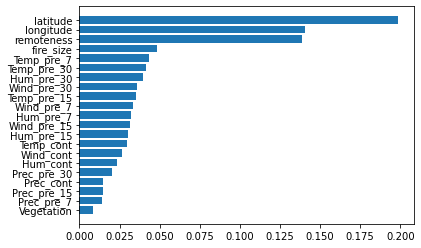

In [10]:
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Gradient Boosting
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
#
# Hyperparameters for GradientBoostingRegressor
#
gbr_params = {'n_estimators': 1000,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
#
# Create an instance of gradient boosting regressor
#
gbr = GradientBoostingRegressor(**gbr_params)
#
# Fit the model
#
gbr.fit(X_train_std, y_train)
#
# Print Coefficient of determination R^2
#
print("Model Accuracy: %.3f" % gbr.score(X_test_std, y_test))
#
# Create the mean squared error
#
mse = mean_squared_error(y_test, gbr.predict(X_test_std))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy: 0.147
The mean squared error (MSE) on test set: 6.5437
